**1. Introduction**

Airline ticket prices are highly dynamic and influenced by multiple interacting factors, including travel demand, seasonality, flight duration, number of stops, route popularity, and airline-specific operational strategies. These drivers often produce complex non-linear relationships that traditional econometric or elasticity-based approaches may fail to capture due to strong linear assumptions and limited feature interaction modeling.

Recent advances in deep learning for tabular data show that neural networks can effectively model such non-linear patterns. In particular, embedding layers provide a compact and expressive representation for high-cardinality categorical variables (e.g., airlines, routes, airports), enabling the model to learn latent similarities across categories. This project applies modern deep learning techniques to predict airline ticket prices and compares their performance with traditional machine learning baselines.

We use the Flight Price Prediction dataset (Kaggle), which includes airline, departure/arrival city, route, number of stops, duration, date, and ticket price. The objective is to build a data-driven model that improves forecasting accuracy and provides insights useful for revenue management and dynamic pricing.

**2. Methodology**

2.1 Data Preprocessing
The objective of data preprocessing is to transform raw flight information into structured numerical representations suitable for deep learning models. Given the heterogeneous nature of airline ticket data—combining categorical attributes, temporal indicators, and continuous numerical features—we apply the following preprocessing steps:

1. Transform flight duration into a continuous numerical feature (minutes)
2. Encode categorical variables using indices for embedding layers
3. Standardize numerical variables
4. Remove extreme outliers
5. Split the dataset into training and test sets

The cleaned dataset already integrates both economy and business class tickets, with ticket class treated as a categorical feature.


In [11]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

DATA_PATH = "/content/Clean_Dataset.csv"
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (300153, 12)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [17]:
# Step1: convert duration to minutes
def duration_to_minutes(x):
    if pd.isna(x):
        return np.nan
    s = str(x).lower()
    hours = 0
    minutes = 0
    if "h" in s:
        hours = int(s.split("h")[0])
    if "m" in s:
        minutes = int(s.split("m")[0].split()[-1])
    return hours * 60 + minutes

df["duration_min"] = df["duration"] * 60

df[["duration", "duration_min"]].head()


,duration,duration_min
0,2.17,130.2
1,2.33,139.8
2,2.17,130.2
3,2.25,135.0
4,2.33,139.8


In [18]:
# Step 2: Categorical encoding (indices for embeddings)
from sklearn.preprocessing import LabelEncoder

cat_cols = [
    "airline",
    "flight",
    "source_city",
    "destination_city",
    "departure_time",
    "arrival_time",
    "stops",
    "class"
]

encoders = {}
cardinalities = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le
    cardinalities[col] = len(le.classes_)

cardinalities


{'airline': 6,
 'flight': 1561,
 'source_city': 6,
 'destination_city': 6,
 'departure_time': 6,
 'arrival_time': 6,
 'stops': 3,
 'class': 2}

In [20]:
# Step 3: Numerical feature standardization
from sklearn.preprocessing import StandardScaler

num_cols = ["duration_min", "days_left"]

# Fill missing values (safe guard)
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
duration_min,300153.0,-9.090311e-18,1.000002,-1.583849,-0.749587,-0.135014,0.549081,5.229290
days_left,300153.0,-6.135960e-17,1.000002,-1.843875,-0.811501,-0.000350,0.884541,1.695692


In [21]:
# Step 4: Outlier removal (IQR on price)
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1

before = len(df)
df = df[(df["price"] >= Q1 - 1.5 * IQR) &
        (df["price"] <= Q3 + 1.5 * IQR)]
after = len(df)

print(f"Removed {before - after} rows ({(before - after)/before:.2%})")


Removed 123 rows (0.04%)


In [22]:
# Step 5: Train / Test split
from sklearn.model_selection import train_test_split
import numpy as np

X_cat = df[cat_cols].values.astype(np.int64)
X_num = df[num_cols].values.astype(np.float32)

# Log-transform target for stable regression
y = np.log1p(df["price"].values.astype(np.float32))

X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat, X_num, y, test_size=0.2, random_state=42
)

print("Train samples:", X_cat_train.shape[0])
print("Test samples :", X_cat_test.shape[0])


Train samples: 240024
Test samples : 60006


**2.2 Exploratory Data Analysis (EDA)**

Exploratory Data Analysis (EDA) is conducted to understand the distributional properties of airline ticket prices and to identify key patterns between flight characteristics and pricing. These insights provide empirical motivation for feature engineering choices and the adoption of non-linear deep learning models.
Specifically, we analyze:
- The distribution of ticket prices and flight duration
- Price variations across airlines, routes, and number of stops
- Correlations among numerical features


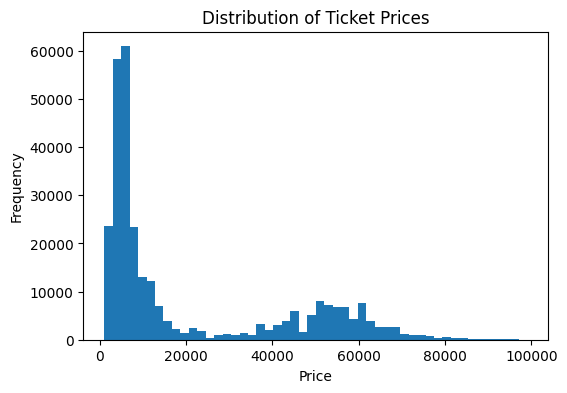

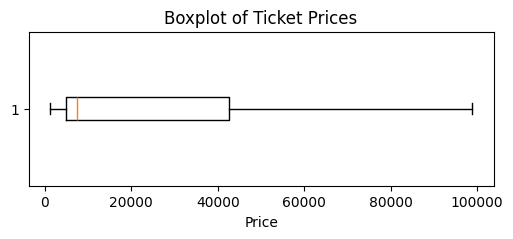

In [23]:
import matplotlib.pyplot as plt

# Price distribution
plt.figure(figsize=(6,4))
plt.hist(df["price"], bins=50)
plt.title("Distribution of Ticket Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,2))
plt.boxplot(df["price"], vert=False)
plt.title("Boxplot of Ticket Prices")
plt.xlabel("Price")
plt.show()


**Observations: Ticket Price**

- Ticket prices exhibit a strongly right-skewed distribution with a long tail of high-priced observations.
- Most tickets are concentrated in the low-to-mid price range, while a small proportion of flights account for extremely high prices.
- The boxplot confirms substantial price variability and the presence of extreme outliers.
- This pattern reflects heterogeneous pricing across airlines, routes, and ticket classes (economy vs. business).

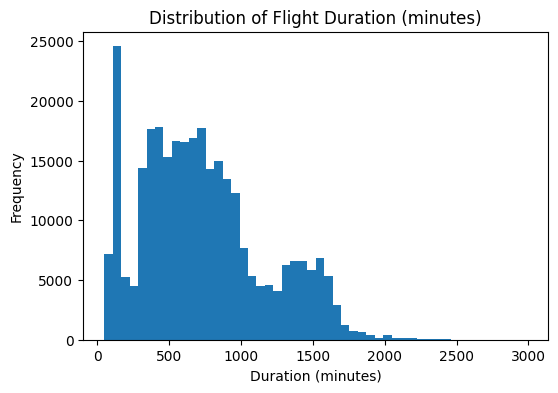

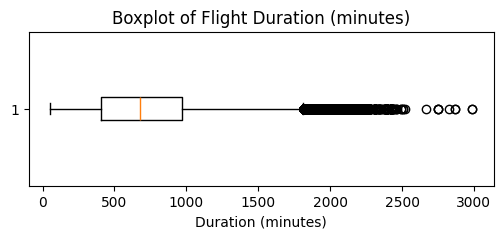

In [33]:
# Duration distribution
plt.figure(figsize=(6,4))
plt.hist(df["duration"] * 60, bins=50)
plt.title("Distribution of Flight Duration (minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,2))
plt.boxplot(df["duration"] * 60, vert=False)
plt.title("Boxplot of Flight Duration (minutes)")
plt.xlabel("Duration (minutes)")
plt.show()


**Observations: Flight Duration**
- Flight duration (in minutes) shows a right-skewed and multimodal distribution.
- The majority of flights fall within short-to-medium haul ranges, while long-haul flights form a heavy upper tail.
- The boxplot reveals several extreme duration outliers, corresponding to long-distance or multi-stop itineraries.
- The non-normal distribution of duration suggests potential non-linear effects on ticket pricing.

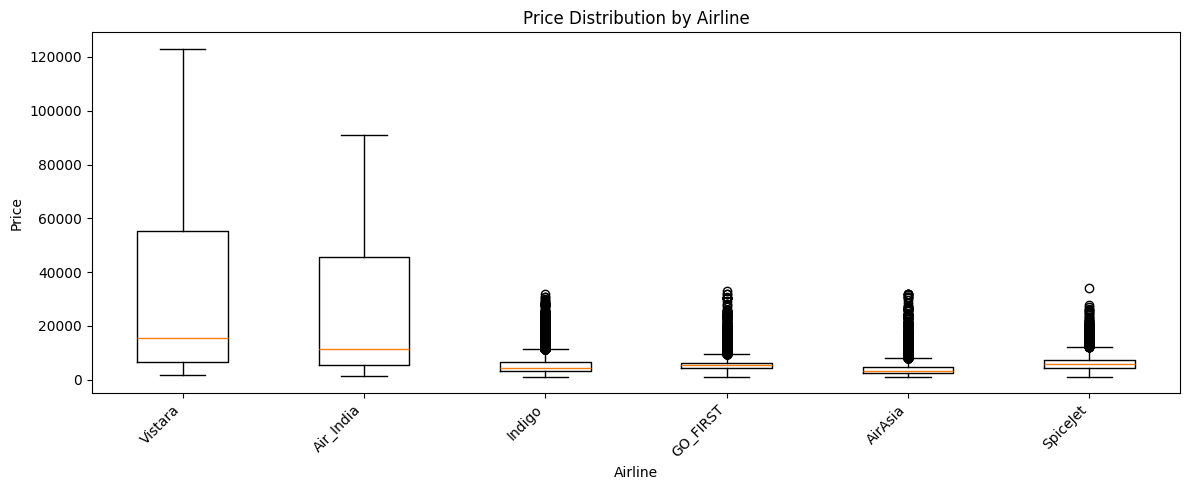

In [53]:
# Price by airline
import pandas as pd
import matplotlib.pyplot as plt

# Read raw data
df_raw = pd.read_csv("/content/Clean_Dataset.csv")

# Get airlines by frequency
top_airlines = df_raw["airline"].value_counts().head(10).index.tolist()

# Prepare price data for boxplot
price_data = []
for airline in top_airlines:
    prices = df_raw.loc[df_raw["airline"] == airline, "price"]
    price_data.append(prices)

plt.figure(figsize=(12, 5))
plt.boxplot(price_data, vert=True, showfliers=True)
plt.title("Price Distribution by Airline")
plt.xlabel("Airline")
plt.ylabel("Price")

plt.xticks(
    ticks=range(1, len(top_airlines) + 1),
    labels=top_airlines,
    rotation=45,
    ha="right"
)

plt.tight_layout()
plt.show()


**Observations: Price by airline**
- Ticket prices vary substantially across airlines, indicating heterogeneous pricing strategies.
- Full-service carriers such as Vistara and Air India exhibit higher median prices and much wider interquartile ranges, reflecting premium services and mixed cabin offerings.
- Low-cost carriers such as Indigo, AirAsia, SpiceJet, and GO FIRST show lower median prices with more compact price distributions, consistent with budget-oriented pricing models.
- Premium airlines display longer upper whiskers and more extreme high-price outliers, suggesting the presence of business-class fares and demand-driven price surges.
- Budget airlines exhibit tighter price ranges, though occasional high-price outliers indicate pricing increases under high demand or limited availability.

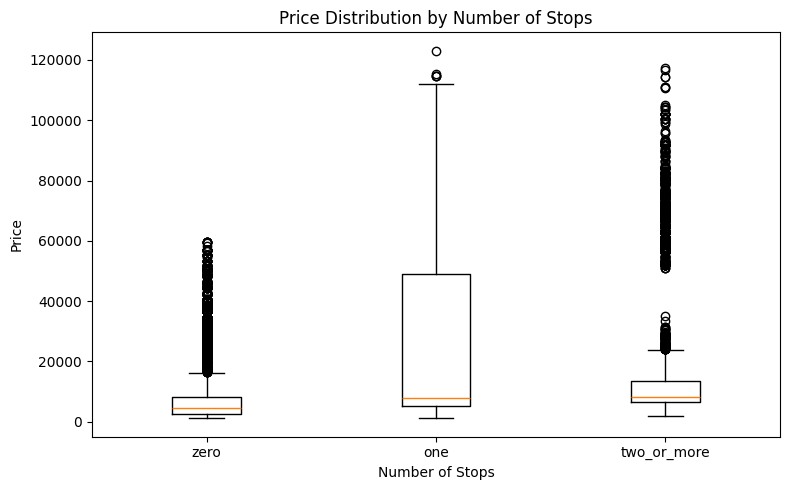

In [55]:
# Price by numbers of stops
import pandas as pd
import matplotlib.pyplot as plt

# Get stop categories directly from data (non-encoded)
stop_order = ["zero", "one", "two_or_more"]
stop_order = [s for s in stop_order if s in df_raw["stops"].unique()]
# Prepare price data for boxplot
price_data = []

for s in stop_order:
    prices = df_raw.loc[df_raw["stops"] == s, "price"]
    price_data.append(prices)

plt.figure(figsize=(8, 5))
plt.boxplot(price_data, vert=True, showfliers=True)
plt.title("Price Distribution by Number of Stops")
plt.xlabel("Number of Stops")
plt.ylabel("Price")

plt.xticks(
    ticks=range(1, len(stop_order) + 1),
    labels=stop_order
)

plt.tight_layout()
plt.show()

**Observations: Price by numbers of stops**
- Ticket prices do not decrease monotonically with the number of stops.
- Non-stop flights (zero) exhibit the lowest median prices and the most compact price distribution.
- One-stop flights (one) show substantially higher price variability, with the widest interquartile range and extreme high-price outliers.
- Flights with two or more stops (two_or_more) display the highest median prices on average and a heavy upper tail.
- The large dispersion and extreme values observed for one and two_or_more stops suggest strong interaction effects between number of stops, route length, and ticket class.

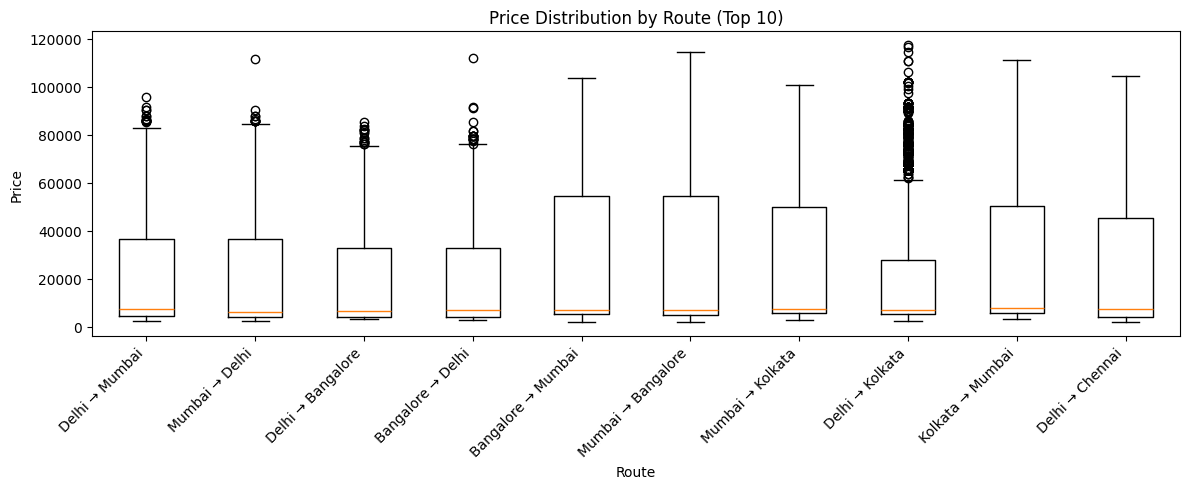

In [57]:
# Price by route (top 10 routes by frequency)
import pandas as pd
import matplotlib.pyplot as plt

# Get top 10 routes by frequency
# Route is defined as source_city -> destination_city
df_raw["route"] = df_raw["source_city"] + " → " + df_raw["destination_city"]

top_routes = df_raw["route"].value_counts().head(10).index.tolist()

# Prepare price data for boxplot
price_data = []
for r in top_routes:
    prices = df_raw.loc[df_raw["route"] == r, "price"]
    price_data.append(prices)

plt.figure(figsize=(12, 5))
plt.boxplot(price_data, vert=True, showfliers=True)
plt.title("Price Distribution by Route (Top 10)")
plt.xlabel("Route")
plt.ylabel("Price")

plt.xticks(
    ticks=range(1, len(top_routes) + 1),
    labels=top_routes,
    rotation=45,
    ha="right"
)

plt.tight_layout()
plt.show()


**Observations: Price by route**
- Ticket prices vary substantially across routes, indicating strong route-specific pricing effects.
- Median prices across major routes are relatively similar, reflecting comparable baseline economy fares in highly competitive markets. Despite similar medians, routes differ substantially in price dispersion and upper-tail behavior.
- Several routes exhibit wide interquartile ranges and long upper tails, reflecting significant price dispersion within the same origin–destination pair.
- Extreme high-price outliers are present across most routes, indicating the influence of premium cabins, long-haul segments, or demand-driven pricing.
- Some routes display relatively compact price distributions, suggesting more stable pricing or stronger competition.
- Overall, the large within-route and across-route variability highlights the importance of route-related features in modeling airline ticket prices.

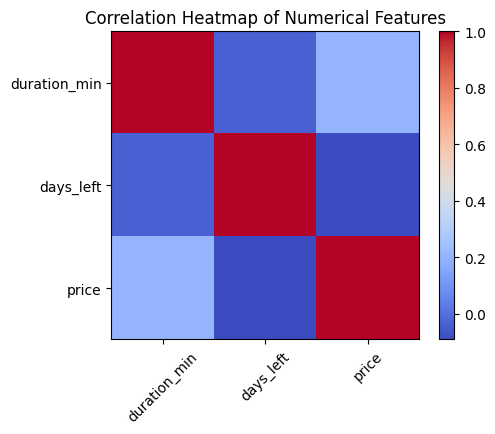

,duration_min,days_left,price
duration_min,1.000000,-0.038959,0.204355
days_left,-0.038959,1.000000,-0.090259
price,0.204355,-0.090259,1.000000


In [29]:
# Correlation heatmap
import numpy as np

num_features = ["duration_min", "days_left", "price"]
corr = df[num_features].corr()

plt.figure(figsize=(5,4))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(num_features)), num_features, rotation=45)
plt.yticks(range(len(num_features)), num_features)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

corr


**Observations: Correlation heatmap**
- Flight duration shows a weak positive correlation with ticket price, indicating that longer flights tend to be more expensive but with substantial variability.
- Days left before departure exhibits a negative correlation with price, reflecting last-minute price increases.
- Overall correlations among numerical features are moderate to weak, suggesting that linear relationships alone are insufficient to explain pricing dynamics.